# This notebook

This notebook contains first bits and pieces of the yet to be developed model correlating climate/environmental factors with conflict occurrence.

## Import libraries and file with settings

In [1]:
import conflict_model

import pandas as pd
import geopandas as gpd
from configparser import RawConfigParser
import matplotlib.pyplot as plt
import numpy as np
import datetime
import netCDF4 as nc
import rasterstats as rstats
import xarray as xr
import rasterio as rio
import seaborn as sbs
from sklearn import svm, preprocessing, model_selection, metrics
import os, sys

In [2]:
conflict_model.utils.show_versions()

Python version: 3.7.7 (default, Apr 15 2020, 05:09:04) [MSC v.1916 64 bit (AMD64)]
conflict_model version: 0.0.1
geopandas version: 0.7.0
xarray version: 0.15.1
rasterio version: 1.1.0
pandas version: 1.0.3
numpy version: 1.18.1
scikit-learn version: 0.22.1
matplotlib version: 3.2.1
seaborn version: 0.10.1
rasterstats version: 0.14.0


Geopandas versions lower than 0.7.0 do not yet have the clip function. The notebook will thus not work with these versions.

In [3]:
if gpd.__version__ < '0.7.0':
    sys.exit('please upgrade geopandas to version 0.7.0, your current version is {}'.format(gpd.__version__))

In this file all the settings for the analysis are defined. By 'parsing' it, all values are read for different sections. This is a simple way to make the code independent of the input data and settings.

In [4]:
settings_file = r'../data/run_setting.cfg'

In [5]:
config = RawConfigParser(allow_no_value=True)
config.read(settings_file)

['../data/run_setting.cfg']

In [6]:
#out_dir
out_dir = config.get('general','output_dir')
if not os.path.isdir(out_dir):
        os.makedirs(out_dir)
print('for the record, saving output to folder {}'.format(out_dir) + os.linesep)

for the record, saving output to folder C:\Users\hoch0001\Documents\_code\conflict_model\data\OUT



# Applying functions

In [7]:
gdf = conflict_model.utils.get_geodataframe(config)

reading csv file to dataframe C:\Users\hoch0001\Documents\_code\conflict_model\data\UCDP/ged191.csv
...DONE

translating to geopandas dataframe
...DONE



In [8]:
conflict_gdf, extent_gdf = conflict_model.selection.select(gdf, config)

filtering on conflict properties...
...filtering key best with lower value 5
...filtering key type_of_violence with value 1
...passing key country as it is empty
focussing on period between 2000 and 2011

reading extent and spatial aggregation level from file C:\Users\hoch0001\Documents\_code\conflict_model\data\waterProvinces/waterProvinces_Africa.shp
...DONE

clipping datasets to extent
...DONE

clipping to climate zones['BWh', 'BSh']
...DONE



# Functions

# Analysis per year

In a first step, we want to know in which countries there was conflict or not. To that end, we first accumulate the number of fatalities per country and use this as proxy whether there was a conlfict or not (guess there is a rather strong like...).

In [9]:
print('simulation period from', str(config.getint('settings', 'y_start')), 'to', str(config.getint('settings', 'y_end')))
print('')

X1 = pd.Series(dtype=float)
X2 = pd.Series(dtype=float)
Y  = pd.Series(dtype=int) # not bool, because otherwise 0 is converted to False and 1 to True but we need 0/1

# go through all simulation years as specified in config-file
for sim_year in np.arange(config.getint('settings', 'y_start'), config.getint('settings', 'y_end'), 1):
    
    print('entering year {}'.format(sim_year) + os.linesep)
    
    list_boolConflict = conflict_model.get_boolean_conflict.conflict_in_year_bool(conflict_gdf, extent_gdf, config, sim_year)
    Y = Y.append(pd.Series(list_boolConflict, dtype=int), ignore_index=True)
    
    list_GDP_PPP = conflict_model.get_var_from_nc.nc_with_integer_timestamp(extent_gdf, config, 'GDP_per_capita_PPP', sim_year)
    X1 = X1.append(pd.Series(list_GDP_PPP), ignore_index=True)
    
    if not len(list_GDP_PPP) == len(list_boolConflict):
        raise AssertionError('length of lists do not match, they are {0} and {1}'.format(len(list_GDP_PPP), len(list_boolConflict)))
    
    list_Evap = conflict_model.get_var_from_nc.nc_with_continous_regular_timestamp(extent_gdf, config, 'total_evaporation', sim_year)
    X2 = X2.append(pd.Series(list_Evap), ignore_index=True)
    
    if not len(list_Evap) == len(list_boolConflict):
        raise AssertionError('length of lists do not match, they are {0} and {1}'.format(len(list_Evap), len(list_boolConflict)))
        
print('...simulation DONE')

simulation period from 2000 to 2011

entering year 2000

determining whether a conflict took place or not
...DONE

calculating mean GDP_per_capita_PPP per aggregation unit from file C:\Users\hoch0001\Documents\_code\conflict_model\data\GDP_HDI/GDP_per_capita_PPP_1990_2015_Africa.nc


C:\Users\hoch0001\AppData\Local\Continuum\anaconda3\envs\conflict_model\lib\site-packages\rasterstats\io.py:301: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")


...DONE

calculating mean total_evaporation per aggregation unit from file C:\Users\hoch0001\Documents\_code\conflict_model\data\PCRGLOBWB/totalEvap/totalEvaporation_monthTot_output_2000_2015_Africa_yearmean.nc


C:\Users\hoch0001\AppData\Local\Continuum\anaconda3\envs\conflict_model\lib\site-packages\rasterstats\io.py:301: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")


...DONE

entering year 2001

determining whether a conflict took place or not
...DONE

calculating mean GDP_per_capita_PPP per aggregation unit from file C:\Users\hoch0001\Documents\_code\conflict_model\data\GDP_HDI/GDP_per_capita_PPP_1990_2015_Africa.nc


C:\Users\hoch0001\AppData\Local\Continuum\anaconda3\envs\conflict_model\lib\site-packages\rasterstats\io.py:301: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")


...DONE

calculating mean total_evaporation per aggregation unit from file C:\Users\hoch0001\Documents\_code\conflict_model\data\PCRGLOBWB/totalEvap/totalEvaporation_monthTot_output_2000_2015_Africa_yearmean.nc


C:\Users\hoch0001\AppData\Local\Continuum\anaconda3\envs\conflict_model\lib\site-packages\rasterstats\io.py:301: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")


...DONE

entering year 2002

determining whether a conflict took place or not
...DONE

calculating mean GDP_per_capita_PPP per aggregation unit from file C:\Users\hoch0001\Documents\_code\conflict_model\data\GDP_HDI/GDP_per_capita_PPP_1990_2015_Africa.nc


C:\Users\hoch0001\AppData\Local\Continuum\anaconda3\envs\conflict_model\lib\site-packages\rasterstats\io.py:301: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")


...DONE

calculating mean total_evaporation per aggregation unit from file C:\Users\hoch0001\Documents\_code\conflict_model\data\PCRGLOBWB/totalEvap/totalEvaporation_monthTot_output_2000_2015_Africa_yearmean.nc


C:\Users\hoch0001\AppData\Local\Continuum\anaconda3\envs\conflict_model\lib\site-packages\rasterstats\io.py:301: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")


...DONE

entering year 2003

determining whether a conflict took place or not
...DONE

calculating mean GDP_per_capita_PPP per aggregation unit from file C:\Users\hoch0001\Documents\_code\conflict_model\data\GDP_HDI/GDP_per_capita_PPP_1990_2015_Africa.nc


C:\Users\hoch0001\AppData\Local\Continuum\anaconda3\envs\conflict_model\lib\site-packages\rasterstats\io.py:301: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")


...DONE

calculating mean total_evaporation per aggregation unit from file C:\Users\hoch0001\Documents\_code\conflict_model\data\PCRGLOBWB/totalEvap/totalEvaporation_monthTot_output_2000_2015_Africa_yearmean.nc


C:\Users\hoch0001\AppData\Local\Continuum\anaconda3\envs\conflict_model\lib\site-packages\rasterstats\io.py:301: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")


...DONE

entering year 2004

determining whether a conflict took place or not
...DONE

calculating mean GDP_per_capita_PPP per aggregation unit from file C:\Users\hoch0001\Documents\_code\conflict_model\data\GDP_HDI/GDP_per_capita_PPP_1990_2015_Africa.nc


C:\Users\hoch0001\AppData\Local\Continuum\anaconda3\envs\conflict_model\lib\site-packages\rasterstats\io.py:301: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")


...DONE

calculating mean total_evaporation per aggregation unit from file C:\Users\hoch0001\Documents\_code\conflict_model\data\PCRGLOBWB/totalEvap/totalEvaporation_monthTot_output_2000_2015_Africa_yearmean.nc


C:\Users\hoch0001\AppData\Local\Continuum\anaconda3\envs\conflict_model\lib\site-packages\rasterstats\io.py:301: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")


...DONE

entering year 2005

determining whether a conflict took place or not
...DONE

calculating mean GDP_per_capita_PPP per aggregation unit from file C:\Users\hoch0001\Documents\_code\conflict_model\data\GDP_HDI/GDP_per_capita_PPP_1990_2015_Africa.nc


C:\Users\hoch0001\AppData\Local\Continuum\anaconda3\envs\conflict_model\lib\site-packages\rasterstats\io.py:301: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")


...DONE

calculating mean total_evaporation per aggregation unit from file C:\Users\hoch0001\Documents\_code\conflict_model\data\PCRGLOBWB/totalEvap/totalEvaporation_monthTot_output_2000_2015_Africa_yearmean.nc


C:\Users\hoch0001\AppData\Local\Continuum\anaconda3\envs\conflict_model\lib\site-packages\rasterstats\io.py:301: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")


...DONE

entering year 2006

determining whether a conflict took place or not
...DONE

calculating mean GDP_per_capita_PPP per aggregation unit from file C:\Users\hoch0001\Documents\_code\conflict_model\data\GDP_HDI/GDP_per_capita_PPP_1990_2015_Africa.nc


C:\Users\hoch0001\AppData\Local\Continuum\anaconda3\envs\conflict_model\lib\site-packages\rasterstats\io.py:301: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")


...DONE

calculating mean total_evaporation per aggregation unit from file C:\Users\hoch0001\Documents\_code\conflict_model\data\PCRGLOBWB/totalEvap/totalEvaporation_monthTot_output_2000_2015_Africa_yearmean.nc


C:\Users\hoch0001\AppData\Local\Continuum\anaconda3\envs\conflict_model\lib\site-packages\rasterstats\io.py:301: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")


...DONE

entering year 2007

determining whether a conflict took place or not
...DONE

calculating mean GDP_per_capita_PPP per aggregation unit from file C:\Users\hoch0001\Documents\_code\conflict_model\data\GDP_HDI/GDP_per_capita_PPP_1990_2015_Africa.nc


C:\Users\hoch0001\AppData\Local\Continuum\anaconda3\envs\conflict_model\lib\site-packages\rasterstats\io.py:301: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")


...DONE

calculating mean total_evaporation per aggregation unit from file C:\Users\hoch0001\Documents\_code\conflict_model\data\PCRGLOBWB/totalEvap/totalEvaporation_monthTot_output_2000_2015_Africa_yearmean.nc


C:\Users\hoch0001\AppData\Local\Continuum\anaconda3\envs\conflict_model\lib\site-packages\rasterstats\io.py:301: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")


...DONE

entering year 2008

determining whether a conflict took place or not
...DONE

calculating mean GDP_per_capita_PPP per aggregation unit from file C:\Users\hoch0001\Documents\_code\conflict_model\data\GDP_HDI/GDP_per_capita_PPP_1990_2015_Africa.nc


C:\Users\hoch0001\AppData\Local\Continuum\anaconda3\envs\conflict_model\lib\site-packages\rasterstats\io.py:301: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")


...DONE

calculating mean total_evaporation per aggregation unit from file C:\Users\hoch0001\Documents\_code\conflict_model\data\PCRGLOBWB/totalEvap/totalEvaporation_monthTot_output_2000_2015_Africa_yearmean.nc


C:\Users\hoch0001\AppData\Local\Continuum\anaconda3\envs\conflict_model\lib\site-packages\rasterstats\io.py:301: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")


...DONE

entering year 2009

determining whether a conflict took place or not
...DONE

calculating mean GDP_per_capita_PPP per aggregation unit from file C:\Users\hoch0001\Documents\_code\conflict_model\data\GDP_HDI/GDP_per_capita_PPP_1990_2015_Africa.nc


C:\Users\hoch0001\AppData\Local\Continuum\anaconda3\envs\conflict_model\lib\site-packages\rasterstats\io.py:301: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")


...DONE

calculating mean total_evaporation per aggregation unit from file C:\Users\hoch0001\Documents\_code\conflict_model\data\PCRGLOBWB/totalEvap/totalEvaporation_monthTot_output_2000_2015_Africa_yearmean.nc


C:\Users\hoch0001\AppData\Local\Continuum\anaconda3\envs\conflict_model\lib\site-packages\rasterstats\io.py:301: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")


...DONE

entering year 2010

determining whether a conflict took place or not
...DONE

calculating mean GDP_per_capita_PPP per aggregation unit from file C:\Users\hoch0001\Documents\_code\conflict_model\data\GDP_HDI/GDP_per_capita_PPP_1990_2015_Africa.nc


C:\Users\hoch0001\AppData\Local\Continuum\anaconda3\envs\conflict_model\lib\site-packages\rasterstats\io.py:301: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")


...DONE

calculating mean total_evaporation per aggregation unit from file C:\Users\hoch0001\Documents\_code\conflict_model\data\PCRGLOBWB/totalEvap/totalEvaporation_monthTot_output_2000_2015_Africa_yearmean.nc


C:\Users\hoch0001\AppData\Local\Continuum\anaconda3\envs\conflict_model\lib\site-packages\rasterstats\io.py:301: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")


...DONE

...simulation DONE


# Machine Learning

## Data preparation

First, create a pandas dataframe from all variables and targets and kick out rows with missing values (they do not work with ML)

In [12]:
XY_data = list(zip(X1, X2, Y))
XY_data = pd.DataFrame(XY_data, columns=['GDP_PPP', 'ET', 'conflict'])
print(len(XY_data))
XY_data = XY_data.dropna()
print(len(XY_data))

4246
4224


In [13]:
XY_data

,GDP_PPP,ET,conflict
0,2361.934264,0.042316,0
1,3104.051687,0.040520,0
2,1192.025215,0.039277,0
3,1275.859490,0.025305,0
4,1182.202026,0.036308,0
...,...,...,...
4241,3277.156738,0.060997,0
4242,3277.156738,0.068696,0
4243,1381.966901,0.048329,0
4244,1390.211488,0.052157,0


Then, convert them to numpy arrays

In [14]:
X = XY_data[['GDP_PPP', 'ET']].to_numpy()
X

array([[2.36193426e+03, 4.23162297e-02],
       [3.10405169e+03, 4.05202232e-02],
       [1.19202521e+03, 3.92765536e-02],
       ...,
       [1.38196690e+03, 4.83292063e-02],
       [1.39021149e+03, 5.21571179e-02],
       [1.39168983e+03, 5.28718745e-02]])

In [15]:
Y = XY_data.conflict.astype(int).to_numpy()
Y

array([0, 0, 0, ..., 0, 0, 0])

Before we can train and predict with the model, we need to scale the variable data and create trainings and test data for both variables and target.

In [26]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(preprocessing.scale(X),
                                                                    Y,
                                                                    test_size=0.7)

The scatterplot of the (two) variables in X looks like this. Also the sample size n is provided.

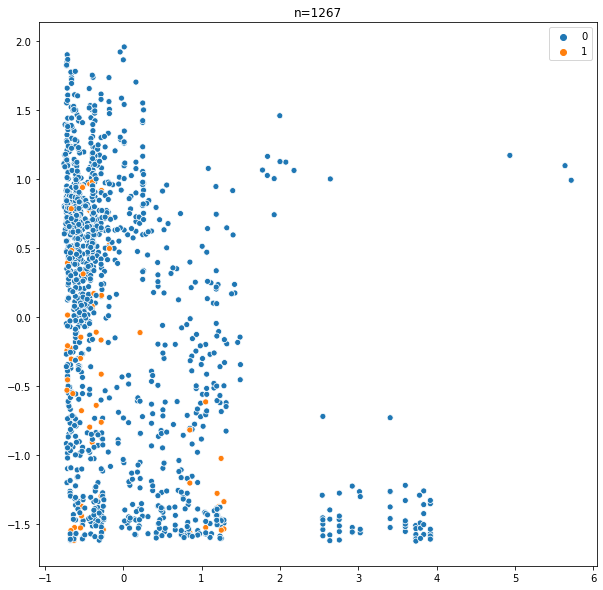

In [27]:
plt.figure(figsize=(10,10))
sbs.scatterplot(x=X_train[:,0],
                y=X_train[:,1],  
                hue=y_train)

plt.title('n=' + str(len(X_train)))
plt.savefig(os.path.join(out_dir, 'scatter_plot.png'), dpi=300)
plt.show()

In [28]:
preprocessing.scale(X).mean(axis=0), preprocessing.scale(X).std(axis=0)

(array([-4.71003707e-17,  6.39219317e-17]), array([1., 1.]))

## Model

### Train and predict

Create Support Vector Classification (SVC) model with balanced weight since data is unbalanced (e.g. many negative and few positive)

In [34]:
clf = svm.SVC(class_weight='balanced', C=0.9)

Fit the model with the scaled training data and the boolean conflict data

In [35]:
clf.fit(X_train, y_train)

SVC(C=0.9, break_ties=False, cache_size=200, class_weight='balanced', coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

Predict something with the scaled predition data

In [36]:
y_pred = clf.predict(X_test)
y_pred

array([0, 0, 0, ..., 0, 1, 0])

No clue right now what this does... look it up!

In [37]:
y_score = clf.decision_function(X_test)
y_score

array([-0.60452387, -1.03416277, -0.95833466, ..., -0.6758252 ,
        1.07185603, -1.04955169])

### Evaluation

The **accuracy** is either the fraction (default) or the count (normalize=False) of correct predictions.

The **precision** is the ratio *tp / (tp + fp)* where tp is the number of true positives and fp the number of false positives. The precision is intuitively the ability of the classifier not to label as positive a sample that is negative.

The **recall** is the ratio *tp / (tp + fn)* where tp is the number of true positives and fn the number of false negatives. The recall is intuitively the ability of the classifier to find all the positive samples.

In [38]:
print("Accuracy:", metrics.accuracy_score(y_test, y_pred))
print("Precision:", metrics.precision_score(y_test, y_pred))
print("Recall:", metrics.recall_score(y_test, y_pred))

Accuracy: 0.6604666892120392
Precision: 0.09620721554116558
Recall: 0.7938931297709924


**Precision-Recall** is a useful measure of success of prediction when the classes are very imbalanced. In information retrieval, precision is a measure of result relevancy, while recall is a measure of how many truly relevant results are returned.

The precision-recall curve shows the tradeoff between precision and recall for different threshold. A high area under the curve represents both high recall and high precision, where high precision relates to a low false positive rate, and high recall relates to a low false negative rate. High scores for both show that the classifier is returning accurate results (high precision), as well as returning a majority of all positive results (high recall).

A system with high recall but low precision returns many results, but most of its predicted labels are incorrect when compared to the training labels. A system with high precision but low recall is just the opposite, returning very few results, but most of its predicted labels are correct when compared to the training labels. An ideal system with high precision and high recall will return many results, with all results labeled correctly.

In [39]:
average_precision = metrics.average_precision_score(y_test, y_score)

print('Average precision-recall score: {0:0.2f}'.format(average_precision))

Average precision-recall score: 0.12


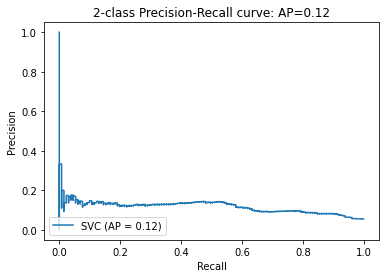

In [40]:
disp = metrics.plot_precision_recall_curve(clf, X_test, y_test)
disp.ax_.set_title('2-class Precision-Recall curve: AP={0:0.2f}'.format(average_precision));

Results are pretty crappy, but that is okay give we use not very sensible input data at the moment...